<a href="https://colab.research.google.com/github/AnshRathore/MachineLearningProject/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
!pip install opendatasets --upgrade --quiet

In [159]:
project_name = 'car_DAN'

In [160]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/kshitij192/cars-image-dataset'
od.download(dataset_url)

Skipping, found downloaded files in "./cars-image-dataset" (use force=True to force download)


In [161]:
import os

DATA_DIR = './cars-image-dataset'
print(os.listdir(DATA_DIR))

['Cars Dataset']


In [162]:
print(os.listdir(DATA_DIR)[:10])

['Cars Dataset']


In [163]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [164]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [165]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [166]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [168]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

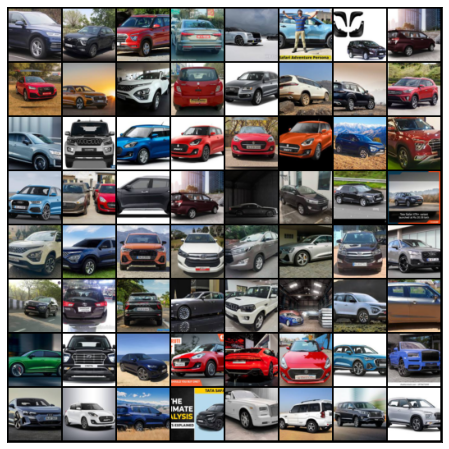

In [169]:
show_batch(train_dl)

In [170]:
!pip install jovian --upgrade --quiet

In [171]:
import jovian

In [172]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [173]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [174]:
device = get_default_device()
device

device(type='cpu')

In [175]:
train_dl = DeviceDataLoader(train_dl, device)

In [176]:
import torch.nn as nn

In [177]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [178]:
discriminator = to_device(discriminator, device)

In [179]:
latent_size = 128

In [180]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


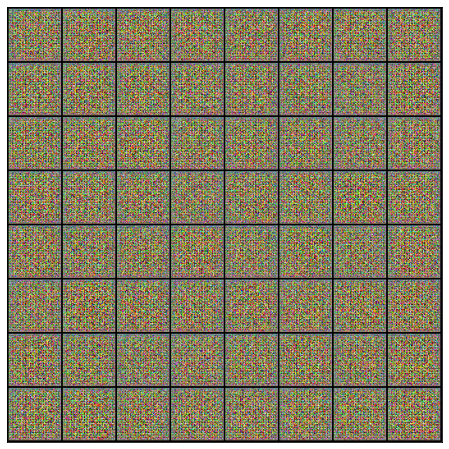

In [181]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [182]:
generator = to_device(generator, device)

In [183]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [184]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [185]:
from torchvision.utils import save_image

In [186]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [187]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [188]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [189]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [190]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [191]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [192]:
lr = 0.0002
epochs = 20

In [193]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [194]:
history = fit(epochs, lr)

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 8.4207, loss_d: 0.2263, real_score: 0.8336, fake_score: 0.0008
Saving generated-images-0001.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 6.7294, loss_d: 0.3602, real_score: 0.8465, fake_score: 0.1535
Saving generated-images-0002.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 3.5341, loss_d: 0.1095, real_score: 0.9543, fake_score: 0.0594
Saving generated-images-0003.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 4.3507, loss_d: 0.4911, real_score: 0.8177, fake_score: 0.2118
Saving generated-images-0004.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 4.3941, loss_d: 1.2935, real_score: 0.8913, fake_score: 0.6147
Saving generated-images-0005.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 2.3582, loss_d: 1.0899, real_score: 0.4220, fake_score: 0.0225
Saving generated-images-0006.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 3.2256, loss_d: 0.4140, real_score: 0.7674, fake_score: 0.0745
Saving generated-images-0007.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 2.0376, loss_d: 0.8414, real_score: 0.5926, fake_score: 0.2033
Saving generated-images-0008.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 2.4823, loss_d: 1.2225, real_score: 0.4180, fake_score: 0.0247
Saving generated-images-0009.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 2.5034, loss_d: 0.2841, real_score: 0.8771, fake_score: 0.1218
Saving generated-images-0010.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 3.9341, loss_d: 0.4430, real_score: 0.8134, fake_score: 0.1692
Saving generated-images-0011.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 3.6735, loss_d: 0.3694, real_score: 0.8444, fake_score: 0.1435
Saving generated-images-0012.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 3.8479, loss_d: 0.3966, real_score: 0.8614, fake_score: 0.2000
Saving generated-images-0013.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 4.6651, loss_d: 0.5609, real_score: 0.9451, fake_score: 0.3594
Saving generated-images-0014.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 2.3111, loss_d: 0.3697, real_score: 0.7588, fake_score: 0.0386
Saving generated-images-0015.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 2.9538, loss_d: 0.4503, real_score: 0.6902, fake_score: 0.0304
Saving generated-images-0016.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 4.7684, loss_d: 0.4172, real_score: 0.7461, fake_score: 0.0337
Saving generated-images-0017.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 3.8923, loss_d: 0.5715, real_score: 0.7834, fake_score: 0.2351
Saving generated-images-0018.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 6.6887, loss_d: 0.7291, real_score: 0.9136, fake_score: 0.4283
Saving generated-images-0019.png


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 3.5751, loss_d: 0.5597, real_score: 0.7773, fake_score: 0.2202
Saving generated-images-0020.png


In [195]:
losses_g, losses_d, real_scores, fake_scores = history

In [196]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [197]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [198]:
from IPython.display import Image

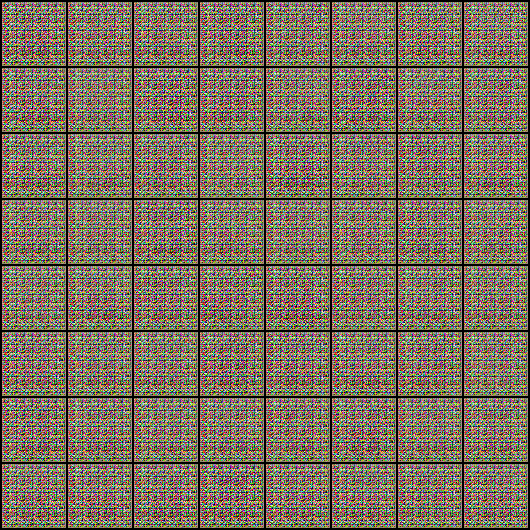

In [199]:
Image('./generated/generated-images-0001.png')


In [ ]:
Image('./generated/generated-images-0001.png')

In [200]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

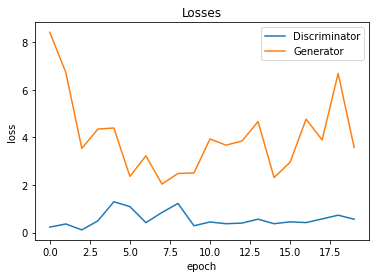

In [201]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

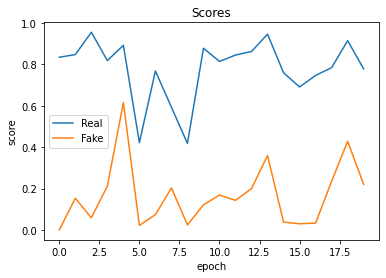

In [202]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');